In [1]:
import torch
from torch.optim import Adam
from utils import expected_calibration_error, plot_reliability_diagram, get_link_labels, accuracy
from models import DeepVGAE
from torch_geometric.utils import negative_sampling
from torch_geometric.datasets.planetoid import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
import os
import numpy as np
from calibrator import LPCC
from utils_calib import *
from tqdm import tqdm

import time
import argparse
import torch.optim as optim

In [2]:
from args_calib import get_args

# Arguments
args = get_args()

In [3]:
args.dataset = 'cora'
args.model_gnn = 'PEG'

In [4]:
device_string = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_string)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

os.makedirs("datasets", exist_ok=True)
dataset = Planetoid("datasets", args.dataset, transform=T.NormalizeFeatures())
data = dataset[0].to(device)
all_edge_index = data.edge_index
data = train_test_split_edges(data, 0.05, 0.1)
data = data.to(device)

path = './models/'

/home/erik/Downloads/lepra/.env/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


## carregando modelo treinado

In [5]:
if args.model_gnn == 'VGAE':
    enc_in_channels = data.x.shape[1]
    enc_hidden_channels = 32
    enc_out_channels = 16
    model = DeepVGAE(enc_in_channels, enc_hidden_channels, enc_out_channels).to(device)
elif args.model_gnn == 'PEG':
    from torch_geometric.utils import to_networkx
    import copy
    from peg_utils import *
    
    train_graph = copy.deepcopy(data)
    train_graph.edge_index = data.train_pos_edge_index
    G = to_networkx(train_graph)
    del train_graph

    

    model_emb = DeepWalk(G,walk_length=80, num_walks=10,workers=1)#init model
    model_emb.train(embed_size = 10)# train model
    emb = model_emb.get_embeddings()# get embedding vectors
    embeddings = []
    for i in range(len(emb)):
        embeddings.append(emb[i])
    embeddings = np.array(embeddings)

    x = data.x
    pos = torch.tensor(embeddings)
    pos = pos.type(torch.FloatTensor)
    x = x.type(torch.FloatTensor)
    
    total_class = 16

    model = Net(in_feats_dim = data.num_features, pos_dim = 128, hidden_dim = total_class, node_dim=data.x.shape[1])

elif args.model_gnn == 'GraphSAGE':
    print('GraphSAGE')
    
ckpt_destilado = torch.load(path + args.model_gnn + '_'+args.dataset+ '_seed_' + str(seed) + '.pth.tar', map_location=torch.device(device))
model.load_state_dict(ckpt_destilado["model_state"]) 

for para in model.parameters():
    para.requires_grad = False

Learning embedding vectors...
Learning embedding vectors done!


### carregando logits e labels de treino, val e teste

In [6]:
model.eval()
prefix= "train"
pos_edge_index_train = data[f'{prefix}_pos_edge_index']
if prefix == 'train':
    neg_edge_index_train = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges
else:
    neg_edge_index = data[f'{prefix}_neg_edge_index']
    
if args.model_gnn == 'VGAE':
    link_logits_train = model.predict(data.x, pos_edge_index_train, neg_edge_index_train)
elif args.model_gnn == 'PEG':
    link_logits_train = model(x, pos, pos_edge_index_train, neg_edge_index_train, data.train_pos_edge_index)

link_labels_train = get_link_labels(pos_edge_index_train, neg_edge_index_train, device) # get link

edge_index_train = torch.cat([pos_edge_index_train, neg_edge_index_train], dim=1)
n_train = edge_index_train.shape[1]

In [7]:
model.eval()
prefix= "val"

pos_edge_index_val = data[f'{prefix}_pos_edge_index']
neg_edge_index_val = data[f'{prefix}_neg_edge_index']

edge_index_val = torch.cat([pos_edge_index_val, neg_edge_index_val], dim=1)
n_val = edge_index_val.shape[1]

if args.model_gnn == 'VGAE':
    link_logits_val = model.predict(data.x, pos_edge_index_train, edge_index_val)[-n_val:]
elif args.model_gnn == 'PEG':
    link_logits_val = model(x, pos, pos_edge_index_val, neg_edge_index_val, data.train_pos_edge_index)

link_labels_val = get_link_labels(pos_edge_index_val, neg_edge_index_val, device) # get link


prefix= "test"
pos_edge_index_test = data[f'{prefix}_pos_edge_index'].to(device)
neg_edge_index_test = data[f'{prefix}_neg_edge_index'].to(device)

edge_index_test = torch.cat([pos_edge_index_test, neg_edge_index_test], dim=1)
n_test = edge_index_test.shape[1]

if args.model_gnn == 'VGAE':
    link_logits_test = model.predict(data.x, pos_edge_index_train, edge_index_test)[-n_test:]
elif args.model_gnn == 'PEG':
    link_logits_test = model(x, pos, pos_edge_index_test, neg_edge_index_test, data.train_pos_edge_index)

link_labels_test = get_link_labels(pos_edge_index_test, neg_edge_index_test, device) # get link

link_labels_val = link_labels_val.type(torch.LongTensor)
link_labels_test = link_labels_test.type(torch.LongTensor)
link_labels_train = link_labels_train.type(torch.LongTensor)

## prepare data

In [8]:
if args.model_gnn == 'VGAE':
    node_embeddings = model.embedding(data.x, pos_edge_index_train)
elif args.model_gnn == 'PEG':
    node_embeddings = model.embedding(x, pos, data.train_pos_edge_index)
    
link_emb_val = agr_emb(pos_edge_index_val, neg_edge_index_val, node_embeddings)
link_emb_test = agr_emb(pos_edge_index_test, neg_edge_index_test, node_embeddings)
link_emb_train= agr_emb(pos_edge_index_train, neg_edge_index_train, node_embeddings)

In [9]:
print(f'val size: {edge_index_val.shape}')
print(f'test size: {edge_index_test.shape}')
print(f'train size: {edge_index_train.shape}')

val size: torch.Size([2, 526])
test size: torch.Size([2, 1054])
train size: torch.Size([2, 17952])


In [10]:
if args.model_gnn == 'VGAE':

    intervential_emb_val = []
    for k in tqdm(get_interventional_emb_vgae(pos_edge_index_train, edge_index_val, model, data.x, device, 'val')):
        intervential_emb_val.append(list(k.detach().numpy()))
    intervential_emb_val = torch.tensor(intervential_emb_val)

    intervential_emb_test = []
    for k in tqdm(get_interventional_emb_vgae(pos_edge_index_train, edge_index_test, model, data.x, device, 'test')):
        intervential_emb_test.append(list(k.detach().numpy()))
    intervential_emb_test = torch.tensor(intervential_emb_test)

    intervential_emb_train = []
    for k in tqdm(get_interventional_emb_vgae(pos_edge_index_train, edge_index_train, model, data.x, device, 'train')):
        intervential_emb_train.append(list(k.detach().numpy()))
    intervential_emb_train = torch.tensor(intervential_emb_train)
    
elif args.model_gnn == 'PEG':
    intervential_emb_val = []
    for k in tqdm(get_interventional_emb_peg(pos, data.train_pos_edge_index, edge_index_val, model, x, device, 'val')):
        intervential_emb_val.append(list(k.detach().numpy()))
    intervential_emb_val = torch.tensor(intervential_emb_val)

    intervential_emb_test = []
    for k in tqdm(get_interventional_emb_peg(pos, data.train_pos_edge_index, edge_index_test, model, x, device, 'test')):
        intervential_emb_test.append(list(k.detach().numpy()))
    intervential_emb_test = torch.tensor(intervential_emb_test)

    intervential_emb_train = []
    for k in tqdm(get_interventional_emb_peg(pos, data.train_pos_edge_index, edge_index_train, model, x, device, 'train')):
        intervential_emb_train.append(list(k.detach().numpy()))
    intervential_emb_train = torch.tensor(intervential_emb_train)

526it [00:11, 44.75it/s]
1054it [00:24, 43.78it/s]
17952it [08:59, 33.27it/s]


In [61]:
args.type_process_emb = 'sub'

In [62]:
if args.type_process_emb == 'dist_signed':
    interv_link_emb_val = (intervential_emb_val - link_emb_val).norm(dim=1).squeeze() * link_logits_val.sign().squeeze()#[:, None].expand_as(link_emb_val)
    interv_link_emb_val = interv_link_emb_val[:, None]

    interv_link_emb_test = (intervential_emb_test - link_emb_test).norm(dim=1).squeeze() * link_logits_test.sign().squeeze()#[:, None].expand_as(link_emb_test)
    interv_link_emb_test = interv_link_emb_test[:, None]

    interv_link_emb_train = (intervential_emb_train - link_emb_train).norm(dim=1).squeeze() * link_logits_train.sign().squeeze()#[:, None].expand_as(link_emb_test)
    interv_link_emb_train = interv_link_emb_train[:, None]
elif args.type_process_emb == 'sub':
    interv_link_emb_val = (intervential_emb_val - link_emb_val)
    interv_link_emb_test = (intervential_emb_test - link_emb_test)
    interv_link_emb_train = (intervential_emb_train - link_emb_train)
elif args.type_process_emb == 'none':
    interv_link_emb_val = link_emb_val#.norm(dim=1).unsqueeze(1)
    interv_link_emb_test = link_emb_test#.norm(dim=1).unsqueeze(1)
    interv_link_emb_train = link_emb_train#.norm(dim=1).unsqueeze(1)
else:
    raise Exception("Use sub or dist!")

## train

In [63]:
criterion = torch.nn.CrossEntropyLoss()

def train(logits_train, logits_val, logits_test, our_calibrator, optimizer, emb_train, emb_val, emb_test, labels_train, labels_val, labels_test,  reg, sign=False):
    t = time.time()
    our_calibrator.train()
    optimizer.zero_grad()

    output_train = our_calibrator(logits_train, emb_train)
    ece_criterion = ECELoss(15, device).to(device)

    output_train, labels_train = output_train.to(device), labels_train.to(device)
    labels_val = labels_val.to(device)
    labels_test = labels_test.to(device)

    ece = ece_criterion(output_train.to(device), labels_train.to(device))
    if sign:
        loss_train = criterion(output_train.to(device), labels_train.to(device)) + (reg[1].to(device) * ece)
    else:
        loss_train = criterion(output_train, labels_train) + (reg[0] * intra_distance_loss(output_train, labels_train)) + (reg[1] *ece)
    acc_train = accuracy(output_train, labels_train)

    loss_train.backward()
    optimizer.step()
    
    with torch.no_grad():
        our_calibrator.eval()
        output_val = our_calibrator(logits_val, emb_val)
        output_test = our_calibrator(logits_test, emb_test)
        loss_val = criterion(output_val, labels_val)
        loss_test = criterion(output_test, labels_test)
        acc_val = accuracy(output_val, labels_val)
        acc_test = accuracy(output_test, labels_test.detach())
        ece_test = ece_criterion(output_test, labels_test)
        ece_val = ece_criterion(output_val, labels_val)
        auc_test = roc_auc_score(labels_test.int().to('cpu'), output_test[:,1].sigmoid().squeeze().to('cpu'))
        auc_val = roc_auc_score(labels_val.int().to('cpu'), output_val[:,1].sigmoid().squeeze().to('cpu'))
    if epoch%100 == 0:
        print(f'epoch: {epoch}',
              f'loss_train: {loss_train.item():.4f}',
              f'acc_train: {acc_train:.4f}',
              f'loss_val: {loss_val.item():.4f}',
              f'acc_val: {loss_val.item():.4f}',
              f'ece_val: {ece_val.item():.4f}',
              f'loss_test: {loss_test.item():.4f}',
              f'acc_test: {acc_test:.4f}',
              f'ece_test: {ece_test.item():.4f}')
    
    return loss_val, acc_val, ece_val, loss_test, acc_test, ece_test, loss_train, acc_train, ece

## main

In [64]:
link_logits_val = link_logits_val.squeeze()
link_logits_test = link_logits_test.squeeze()
link_logits_train = link_logits_train.squeeze()

In [101]:
eces_test = []
aucs_test = []
hit20_list = []
hit50_list = []

epochs = 10000#args.epochs
torch.manual_seed(args.seed)

loss_train_list =[]
loss_val_list = []
loss_test_list = []

acc_train_list =[]
acc_val_list = []
acc_test_list = []

ece_val_list = []
ece_test_list = []
ece_train_list = []


feat = interv_link_emb_val.shape[1]
calib = LPCC(feat, 50, 128, args.dropout, False, args.type_scaling).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, calib.parameters()),
                        lr=0.000001, weight_decay=args.weight_decay)
best = 100
for epoch in range(epochs):
    loss_val, acc_val, ece_val, loss_test, acc_test, ece_test, loss_train, acc_train, ece_train  = train(link_logits_train.unsqueeze(1).detach(),
                                                    link_logits_val.unsqueeze(1).detach(),
                                                    link_logits_test.unsqueeze(1).detach(),
                                                    calib,
                                                    optimizer, 
                                                    interv_link_emb_train.detach(),
                                                    interv_link_emb_val.detach(),
                                                    interv_link_emb_test.detach(),
                                                    link_labels_train.detach(),
                                                    link_labels_val.detach(),
                                                    link_labels_test.detach(),
                                                    torch.tensor((1.0, 1.0)).to(device),
                                                    False)
    loss_train_list.append(loss_train.item())
    loss_val_list.append(loss_val.item())
    loss_test_list.append(loss_test.item())
    
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    acc_test_list.append(acc_test)
    
    ece_val_list.append(ece_val.item())
    ece_test_list.append(ece_test.item())
    ece_train_list.append(ece_train.item())
    
    if ece_val.item() < best:
        best = ece_val.item()
        torch.save(calib.state_dict(),  path + args.model_gnn + '_' + args.dataset + '_vlink_seed_' + str(args.seed)  + '.pth')
        

epoch: 0 loss_train: 1.5578 acc_train: 0.0773 loss_val: 0.8080 acc_val: 0.8080 ece_val: 0.3418 loss_test: 0.8296 acc_test: 0.2002 ece_test: 0.3609
epoch: 100 loss_train: 1.5046 acc_train: 0.1050 loss_val: 0.7856 acc_val: 0.7856 ece_val: 0.3241 loss_test: 0.8019 acc_test: 0.2078 ece_test: 0.3442
epoch: 200 loss_train: 1.4532 acc_train: 0.1471 loss_val: 0.7649 acc_val: 0.7649 ece_val: 0.2918 loss_test: 0.7763 acc_test: 0.2381 ece_test: 0.3057
epoch: 300 loss_train: 1.4057 acc_train: 0.2057 loss_val: 0.7463 acc_val: 0.7463 ece_val: 0.2301 loss_test: 0.7536 acc_test: 0.2818 ece_test: 0.2560
epoch: 400 loss_train: 1.3629 acc_train: 0.2695 loss_val: 0.7299 acc_val: 0.7299 ece_val: 0.1794 loss_test: 0.7336 acc_test: 0.3482 ece_test: 0.1860
epoch: 500 loss_train: 1.3244 acc_train: 0.3307 loss_val: 0.7154 acc_val: 0.7154 ece_val: 0.1355 loss_test: 0.7161 acc_test: 0.4023 ece_test: 0.1308
epoch: 600 loss_train: 1.2893 acc_train: 0.3866 loss_val: 0.7025 acc_val: 0.7025 ece_val: 0.0762 loss_test: 

epoch: 5500 loss_train: 1.2241 acc_train: 0.9777 loss_val: 0.6184 acc_val: 0.6184 ece_val: 0.1492 loss_test: 0.5458 acc_test: 0.8102 ece_test: 0.1412
epoch: 5600 loss_train: 1.2133 acc_train: 0.9777 loss_val: 0.6202 acc_val: 0.6202 ece_val: 0.1497 loss_test: 0.5461 acc_test: 0.8102 ece_test: 0.1400
epoch: 5700 loss_train: 1.2027 acc_train: 0.9777 loss_val: 0.6220 acc_val: 0.6220 ece_val: 0.1460 loss_test: 0.5465 acc_test: 0.8102 ece_test: 0.1392
epoch: 5800 loss_train: 1.1922 acc_train: 0.9777 loss_val: 0.6238 acc_val: 0.6238 ece_val: 0.1423 loss_test: 0.5470 acc_test: 0.8102 ece_test: 0.1405
epoch: 5900 loss_train: 1.1818 acc_train: 0.9777 loss_val: 0.6257 acc_val: 0.6257 ece_val: 0.1440 loss_test: 0.5474 acc_test: 0.8102 ece_test: 0.1427
epoch: 6000 loss_train: 1.1716 acc_train: 0.9777 loss_val: 0.6277 acc_val: 0.6277 ece_val: 0.1419 loss_test: 0.5480 acc_test: 0.8102 ece_test: 0.1406
epoch: 6100 loss_train: 1.1615 acc_train: 0.9777 loss_val: 0.6297 acc_val: 0.6297 ece_val: 0.1397 lo

In [102]:
# torch.save(calib.state_dict(), path + args.model_gnn + '_' + args.dataset + '_vlink_seed_' + str(args.seed)  + '.pth')
auc_test_real = roc_auc_score(link_labels_test.int().to(device), link_logits_test.sigmoid().squeeze().to(device))


state_dict = torch.load( path + args.model_gnn + '_' + args.dataset + '_vlink_seed_' + str(args.seed)  + '.pth')
model3 = LPCC(feat, 50, 128, args.dropout, False, args.type_scaling).to(device)
model3.load_state_dict(state_dict)
model3.eval()
model3 = model3.to(device)


output_test = model3(link_logits_test.unsqueeze(1), interv_link_emb_test)
auc_test_pred = roc_auc_score(link_labels_test.int().cpu(), output_test[:,1].sigmoid().squeeze().detach().cpu())
ece_criterion = ECELoss(15, device).cuda()
ece = ece_criterion(output_test, link_labels_test)
eces_test = ece.item()
aucs_test = auc_test_pred.item()

print(f'ece: {round(eces_test,4)}')
print(f'auc: {round(aucs_test,4)}')

ece: 0.0469
auc: 0.5996


/tmp/ipykernel_11779/1395196432.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


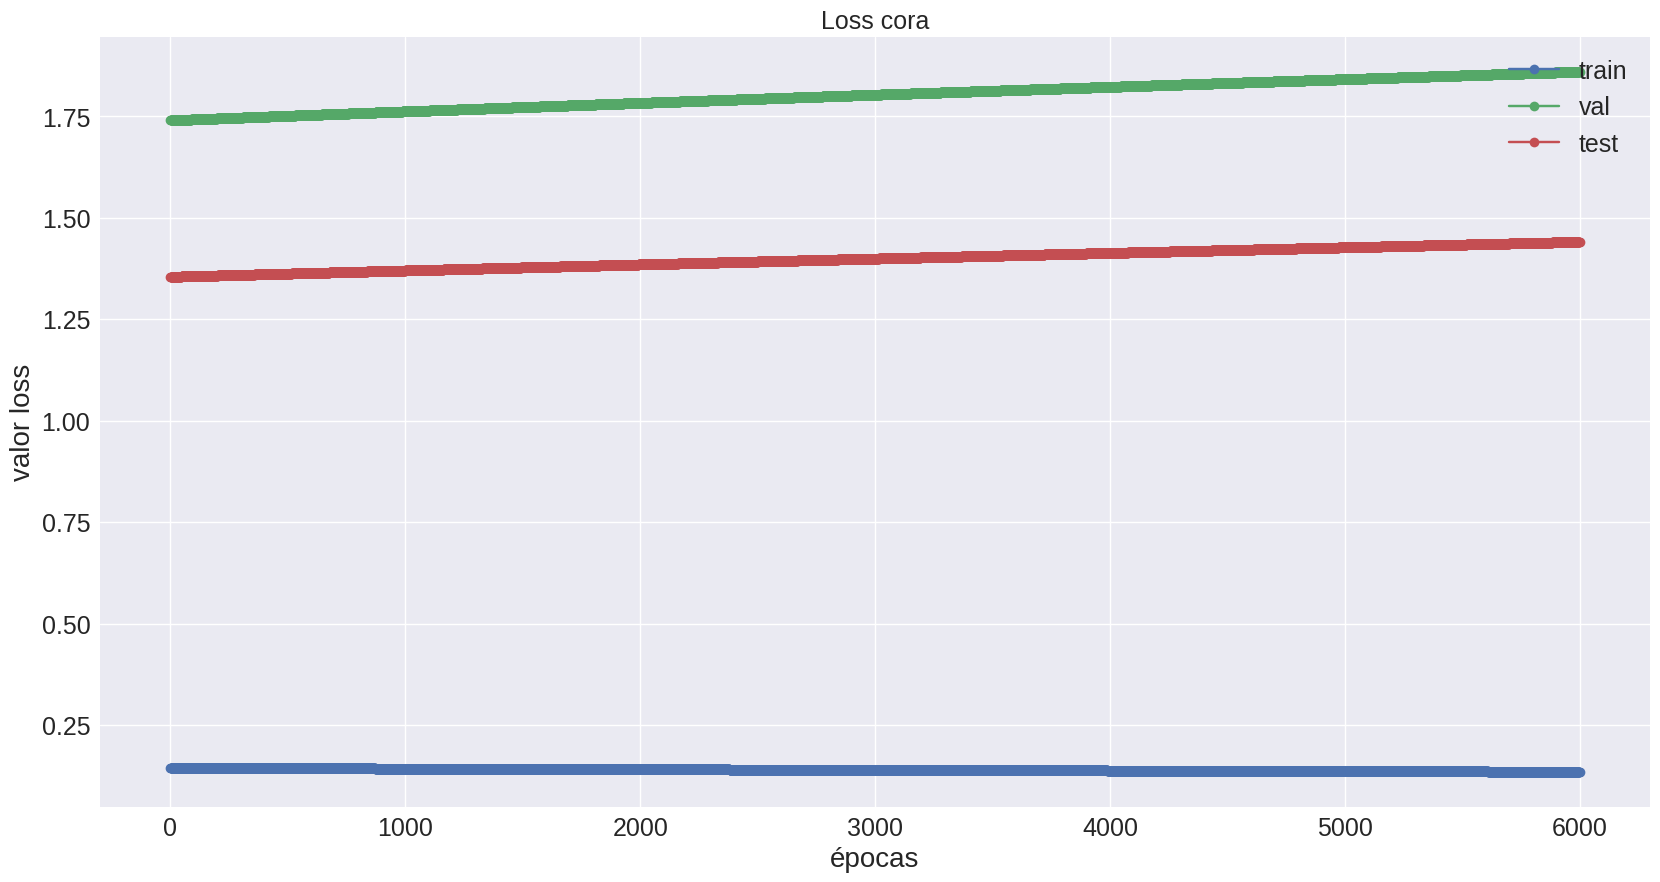

In [87]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(20,10))
plt.plot(np.arange(epochs), loss_train_list, 'o-', label="train")
plt.plot(np.arange(epochs),loss_val_list, 'o-', label="val")
plt.plot(np.arange(epochs), loss_test_list, 'o-', label="test")

plt.title("Loss "+args.dataset)
plt.xlabel("épocas")
plt.ylabel("valor loss")
plt.legend(loc="upper right")
plt.show()

/tmp/ipykernel_11779/572988541.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


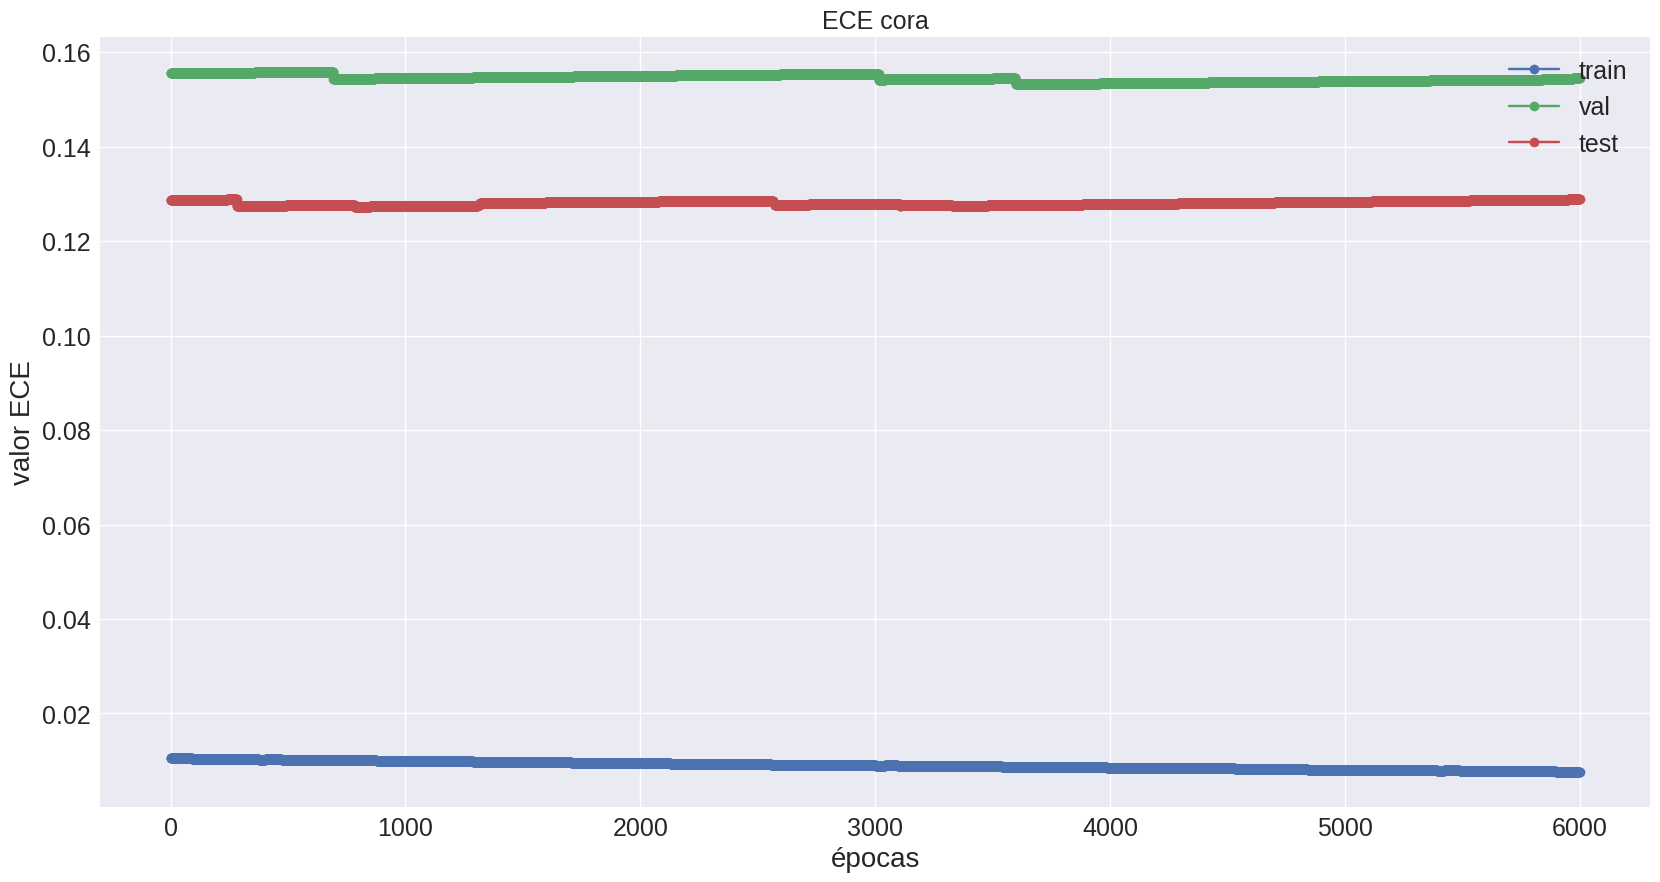

In [88]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(20,10))
plt.plot(np.arange(epochs), ece_train_list, 'o-', label="train")
plt.plot(np.arange(epochs),ece_val_list, 'o-', label="val")
plt.plot(np.arange(epochs), ece_test_list, 'o-', label="test")

plt.title("ECE "+args.dataset)
plt.xlabel("épocas")
plt.ylabel("valor ECE")
plt.legend(loc="upper right")
plt.show()

/tmp/ipykernel_11779/288564629.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


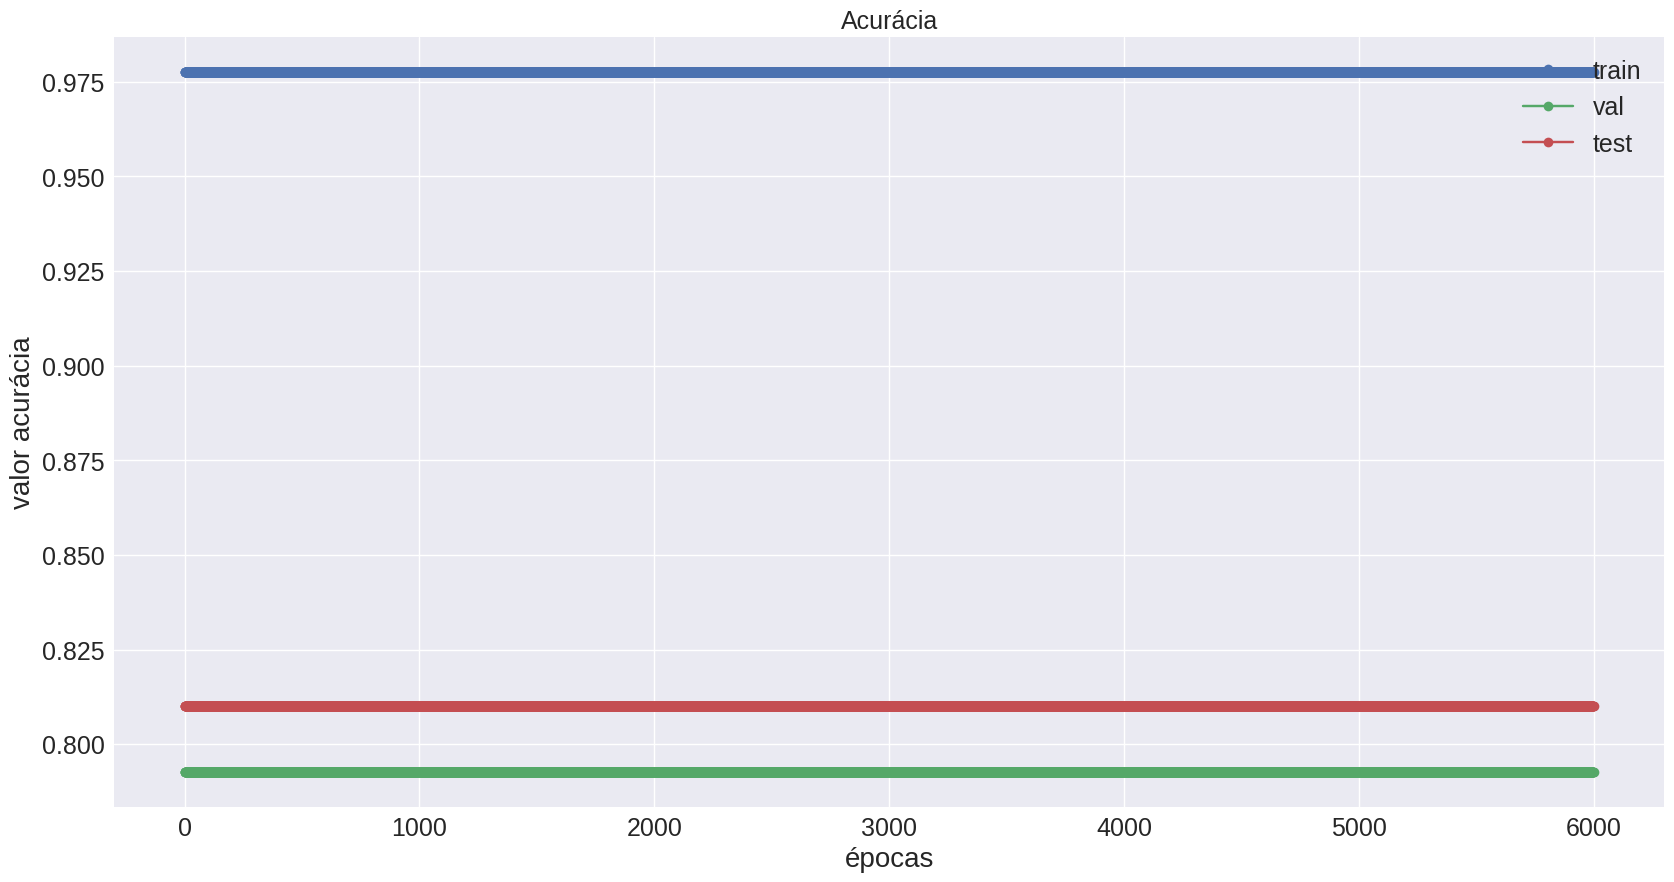

In [89]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(20,10))
plt.plot(np.arange(epochs), acc_train_list, 'o-', label="train")
plt.plot(np.arange(epochs),acc_val_list, 'o-', label="val")
plt.plot(np.arange(epochs), acc_test_list, 'o-', label="test")

plt.title("Acurácia")
plt.xlabel("épocas")
plt.ylabel("valor acurácia")
plt.legend(loc="upper right")
plt.show()

In [90]:
prob_pos_rfc = output_test[:,1].sigmoid().detach().numpy()
#prob_pos_rfc = link_logits_test.squeeze().sigmoid().detach().numpy()

In [91]:
probits = torch.cat(((-link_logits_test).sigmoid().unsqueeze(1), link_logits_test.sigmoid().unsqueeze(1)), dim=1)
entropy = -((probits[:, 0] * torch.log(probits[:, 0])) + ((probits[:, 1] * torch.log(probits[:, 1]))))
entropy.mean()

tensor(0.2042)

In [92]:
probits = np.concatenate(
    ((1-prob_pos_rfc).reshape(-1,1), 
     prob_pos_rfc.reshape(-1,1)), axis=1)

from scipy import sparse
# a=np.array([[1,0,1],[0,0,1]])
P=sparse.csr_matrix(probits)


log_result = np.log(P.data)
logP = P._with_data(log_result, copy=True)
mult_P = P.multiply(logP)
entropy_list = -(mult_P.sum(axis=1))
entropy_list.mean()

0.26343685

In [93]:
all_edge_index = dataset[0].edge_index

In [94]:
from torch_geometric.utils import to_dense_adj
A_adj = to_dense_adj(all_edge_index).squeeze()
A_degre = A_adj.sum(dim=1)

In [95]:
bin = 10
bins = np.linspace(0.0, 1.0, bin + 1)
binids = np.searchsorted(bins[1:-1], prob_pos_rfc)
bin_sums = np.bincount(binids, weights=prob_pos_rfc, minlength=len(bins))
bin_total = np.bincount(binids, minlength=len(bins))
nonzero = bin_total != 0

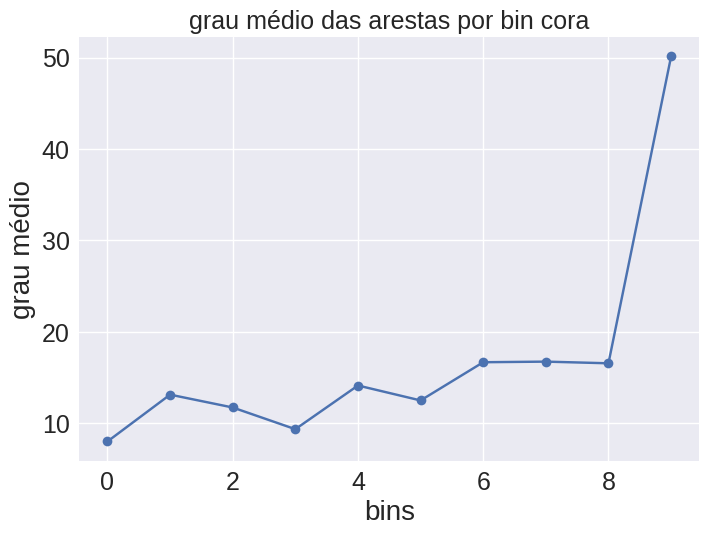

In [96]:
test_edges = torch.cat((pos_edge_index_test, neg_edge_index_test), dim=1)
edge_degree = A_degre[test_edges[0,:]] + A_degre[test_edges[1,:]]
sum_degree = np.bincount(binids, 
                         weights=edge_degree.detach().numpy(), 
                         minlength=len(bins))
media_degree = sum_degree[nonzero] / bin_total[nonzero]
media_degree

plt.plot(np.where(nonzero == True)[0], media_degree, '-o')
plt.title('grau médio das arestas por bin '+ args.dataset)
plt.xlabel('bins')
plt.ylabel('grau médio')
plt.show()

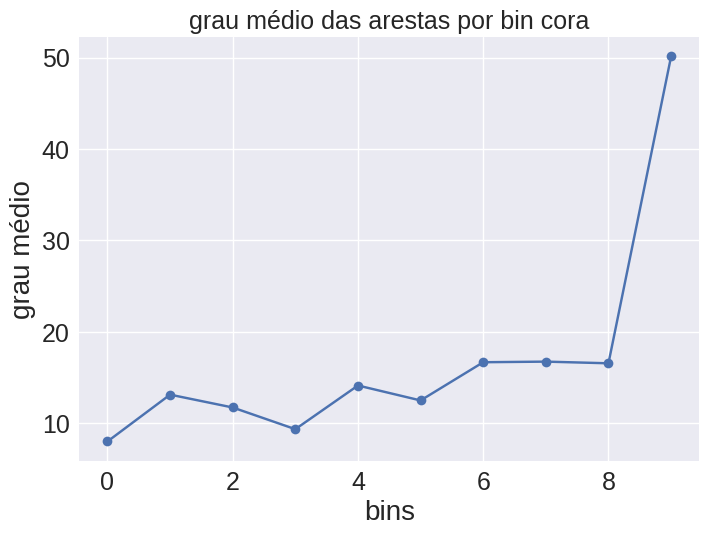

In [97]:
test_edges = torch.cat((pos_edge_index_test, neg_edge_index_test), dim=1)
edge_degree = A_degre[test_edges[0,:]] + A_degre[test_edges[1,:]]
sum_degree = np.bincount(binids, 
                         weights=edge_degree.detach().numpy(), 
                         minlength=len(bins))
media_degree = sum_degree[nonzero] / bin_total[nonzero]
media_degree

plt.plot(np.where(nonzero == True)[0], media_degree, '-o')
plt.title('grau médio das arestas por bin '+ args.dataset)
plt.xlabel('bins')
plt.ylabel('grau médio')
plt.show()

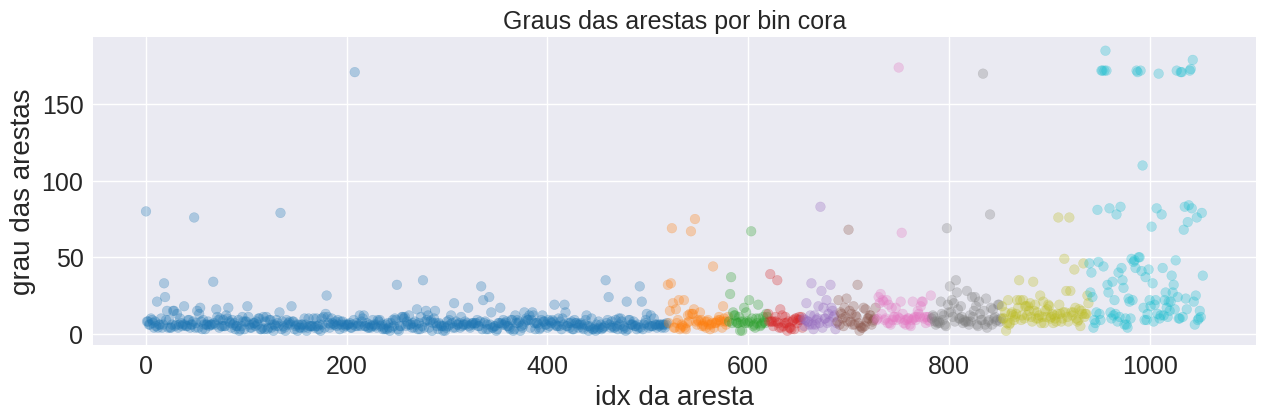

In [98]:
eixo_y = []
colors = []
for i in range(bin):
    lepra = edge_degree.numpy()[np.where(binids == i)[0]]
    eixo_y.extend(lepra)
    colors.extend(np.zeros(len(lepra))+i)

plt.figure(figsize=(15,4))
plt.scatter(np.arange(len(eixo_y)), eixo_y, c=colors, alpha=0.3, cmap='tab10')
plt.title('Graus das arestas por bin ' + args.dataset)
plt.xlabel('idx da aresta')
plt.ylabel('grau das arestas')
plt.show()